# **AI Image Authenticity Detector — README**

## **📌 Project Summary**

This project builds a deep-learning system that classifies whether an image is **Real** or **AI-Generated**.
Two models were trained and evaluated:

* **ResNet50** (best-performing)
* **EfficientNet-B0**

The notebook includes training, evaluation, confusion matrices, classification reports, and an upload interface for user testing.

---

## **📁 Dataset (Public)**

We use the public Kaggle dataset:

🔗 **AI Generated Images vs Real Images**
[https://www.kaggle.com/datasets/tristanzhang32/ai-generated-images-vs-real-images](https://www.kaggle.com/datasets/tristanzhang32/ai-generated-images-vs-real-images)

you can access the data set in colab from this link:
https://drive.google.com/drive/folders/1pgTEdEhLF2EL5Kbz8WLrkPic2gROjL10?usp=sharing

you can access the saved models via this link:
https://drive.google.com/drive/folders/1rRDIpijU0PxmeMZ_GQcoCPj3TDEaRWYd?usp=sharing

### **Classes**

* **Real**
* **AI (Fake)**

### **Preprocessing**

* Resize to **224×224**
* Normalization (ImageNet)
* Light augmentation (rotation, flip, jitter)

---

## **📊 Model Performance**

### **ResNet50**

* High accuracy
* Strong precision/recall for both classes
* Best overall model for deployment

### **EfficientNet-B0**

* Faster but less accurate
* Sometimes struggles with AI images

---

## **🚀 Features Included in This Notebook**

* Train ResNet50 & EfficientNetB0
* Save models to Google Drive
* Evaluate using:

  * Classification report
  * Confusion matrix
  * Accuracy & loss curves
* Test on sample images
* Upload your own image to get:

  * **Prediction (Real / AI)**
  * **Confidence score**

---

## **📬 Notes**

* Dataset must be downloaded  before running.
* Paths in the notebook are set so anyone can run it easily.



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Import Libraries & Configuration


In [ ]:
# Imports
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.optimizers import Adam

# Paths
DATA_ROOT = Path('/content/drive/MyDrive/Image Authenticity Detector/dataset')
TRAIN_DIR = DATA_ROOT / 'train'
VAL_DIR = DATA_ROOT / 'val'
TEST_DIR = DATA_ROOT / 'test'

# Config
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10


### Remove Corrupted Images
Before training, we check all images and remove any corrupted or empty files that would cause errors during model loading.


In [ ]:
from PIL import Image
import os

def remove_corrupted_images(folder):
    count = 0
    corrupted_list = []
    for class_folder in folder.iterdir():
        if class_folder.is_dir():
            for img_path in class_folder.glob('*'):
                try:
                    with Image.open(img_path) as img:
                        img.load()  # Attempt to fully load the image data
                        # Optionally, try resizing to catch more issues, though load() often suffices
                        # img.resize((10,10))
                except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
                    print(f"Corrupted image found: {img_path} - {e}")
                    corrupted_list.append(img_path)
                    count += 1

    for img_path in corrupted_list:
        print(f"Removing corrupted image: {img_path}")
        img_path.unlink()  # Delete the corrupted file

    print(f"Total corrupted images removed in {folder}: {count}")

# Run for all dataset folders
print("Running enhanced image corruption check...")
remove_corrupted_images(TRAIN_DIR)
remove_corrupted_images(VAL_DIR)
remove_corrupted_images(TEST_DIR)

print("\nImage corruption check complete. Please re-run the cell initializing the data loaders (if any images were removed) and then retry training.")

Running enhanced image corruption check...
Corrupted image found: /content/drive/MyDrive/Image Authenticity Detector/dataset/train/Real/train1032.jpg - image file is truncated (0 bytes not processed)
Removing corrupted image: /content/drive/MyDrive/Image Authenticity Detector/dataset/train/Real/train1032.jpg
Total corrupted images removed in /content/drive/MyDrive/Image Authenticity Detector/dataset/train: 1
Total corrupted images removed in /content/drive/MyDrive/Image Authenticity Detector/dataset/val: 0
Total corrupted images removed in /content/drive/MyDrive/Image Authenticity Detector/dataset/test: 0

Image corruption check complete. Please re-run the cell initializing the data loaders (if any images were removed) and then retry training.


## Check Dataset Size


In [ ]:
# Function to count images in each folder
def count_images(folder):
    counts = {}
    for subfolder in folder.iterdir():
        if subfolder.is_dir():
            counts[subfolder.name] = len(list(subfolder.glob('*')))
    return counts

# Count images
train_counts = count_images(TRAIN_DIR)
val_counts = count_images(VAL_DIR)
test_counts = count_images(TEST_DIR)

print("Training set:", train_counts)
print("Validation set:", val_counts)
print("Test set:", test_counts)


Training set: {'AI': 1050, 'Real': 1049}
Validation set: {'Real': 150, 'AI': 150}
Test set: {'AI': 313, 'Real': 300}


# Show Sample Images
Display a few sample images from both classes (`Real` and `AI`) before preprocessing.

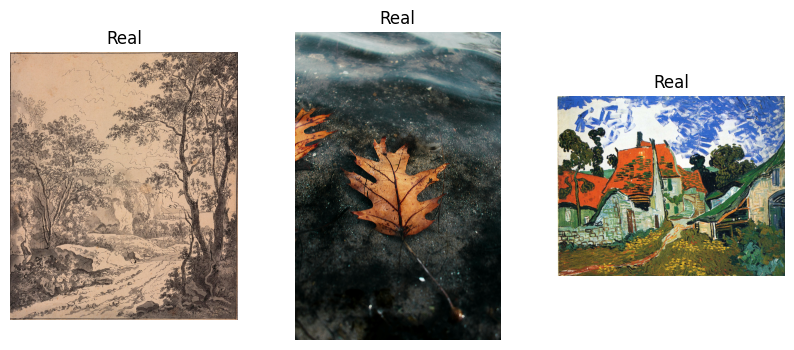

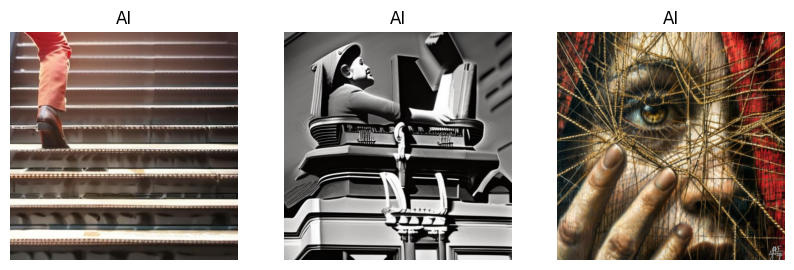

In [ ]:
import random
import matplotlib.image as mpimg

def show_sample_images(folder, category, n=3):
    images = list((folder / category).glob('*'))
    sampled = random.sample(images, n)
    plt.figure(figsize=(10, 4))
    for i, img_path in enumerate(sampled):
        img = mpimg.imread(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.show()

show_sample_images(TRAIN_DIR, 'Real')
show_sample_images(TRAIN_DIR, 'AI')


### Data Preprocessing
We normalize images and apply data augmentation on the training set to improve generalization. Validation and test sets are only rescaled.


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_loader = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)
val_loader = val_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)
test_loader = test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)


Found 2099 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 613 images belonging to 2 classes.


# Build & Fine-tune ResNet50

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ResNet50 base
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in resnet_base.layers[:-30]:
    layer.trainable = False
for layer in resnet_base.layers[-30:]:
    layer.trainable = True

resnet_model = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint_res = ModelCheckpoint('resnet50_best.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
callbacks_res = [checkpoint_res, EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)]

resnet_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 14,712,577 (56.12 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

# Train ResNet50 Model

In [ ]:
resnet_history = resnet_model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=EPOCHS,
    callbacks=callbacks_res
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6304 - loss: 0.6527
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to resnet50_best.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 494s 7s/step - accuracy: 0.6310 - loss: 0.6520 - val_accuracy: 0.5000 - val_loss: 0.7142 - learning_rate: 1.0000e-04
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7104 - loss: 0.5724
Epoch 2: val_accuracy improved from 0.50000 to 0.50333, saving model to resnet50_best.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 475s 7s/step - accuracy: 0.7103 - loss: 0.5724 - val_accuracy: 0.5033 - val_loss: 0.9823 - learning_rate: 1.0000e-04
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6952 - loss: 0.5677
Epoch 3: val_accuracy improved from 0.50333 to 0.74333, saving model to resnet50_best.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 464s 7s/step - accuracy: 0.6955 - loss: 0.5675 - val_accuracy: 0.7433 - val_loss: 0.5047 - learning_rate: 1.0000e-04
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7322 - loss: 0.5365
Epoch 4: val_accuracy did not improve from 0.74333
66/66 ━━━━━━━━━━━━━━━━━━━━ 474s 7s/step - accuracy: 0.7322 - loss: 0.5365 - val_accuracy: 0.5367 - val_loss: 1.2598 - learning_rate: 1.0000e-04
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7188 - loss: 0.5307
Epoch 5: val_accuracy did not improve from 0.74333
66/66 ━━━━━━━━━━━━━━━━━━━━ 482s 7s/step - accuracy: 0.7189 - loss: 0.5306 - val_accuracy: 0.7000 - val_loss: 0.6323 - learning_rate: 1.0000e-04
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7563 - loss: 0.5265
Epoch 6: val_accuracy improved from 0.74333 to 0.76333, saving model to resnet50_best.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 474s 7s/step - accuracy: 0.7562 - loss: 0.5264 - val_accuracy: 0.7633 - val_loss: 0.4616 - learning_rate: 1.0000e-04
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7464 - loss: 0.5167
Epoch 7: val_accuracy improved from 0.76333 to 0.77667, saving model to resnet50_best.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 467s 7s/step - accuracy: 0.7464 - loss: 0.5167 - val_accuracy: 0.7767 - val_loss: 0.4414 - learning_rate: 1.0000e-04
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7572 - loss: 0.5205
Epoch 8: val_accuracy did not improve from 0.77667
66/66 ━━━━━━━━━━━━━━━━━━━━ 474s 7s/step - accuracy: 0.7572 - loss: 0.5204 - val_accuracy: 0.7500 - val_loss: 0.4737 - learning_rate: 1.0000e-04
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7635 - loss: 0.5022
Epoch 9: val_accuracy did not improve from 0.77667
66/66 ━━━━━━━━━━━━━━━━━━━━ 480s 7s/step - accuracy: 0.7635 - loss: 0.5022 - val_accuracy: 0.7667 - val_loss: 0.4653 - learning_rate: 1.0000e-04
Epoch 10/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7513 - loss: 0.5036
Epoch 10: val_accuracy did not improve from 0.77667
66/66 ━━━━━━━━━━━━━━━━━━━━ 477s 7s/step - accuracy: 0.7512 - loss: 0.5036 - val_accuracy: 0.7100 - val_loss: 0.6620 - learning_rate: 1.0000e-04


# Build & Fine-tune EfficientNetB0

In [ ]:
eff_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in eff_base.layers[:-20]:
    layer.trainable = False
for layer in eff_base.layers[-20:]:
    layer.trainable = True

eff_model = Sequential([
    eff_base,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

eff_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

checkpoint_eff = ModelCheckpoint('efficientnetb0_best.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
callbacks_eff = [checkpoint_eff, EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)]

eff_model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 1,515,057 (5.78 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

# Train EfficientNetB0

In [ ]:
eff_history = eff_model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=EPOCHS,
    callbacks=callbacks_eff
)


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5343 - loss: 0.7019
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to efficientnetb0_best.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.5341 - loss: 0.7019 - val_accuracy: 0.5000 - val_loss: 0.6948 - learning_rate: 1.0000e-04
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5136 - loss: 0.7005
Epoch 2: val_accuracy did not improve from 0.50000
66/66 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.5136 - loss: 0.7005 - val_accuracy: 0.5000 - val_loss: 0.6992 - learning_rate: 1.0000e-04
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5292 - loss: 0.6912
Epoch 3: val_accuracy did not improve from 0.50000
66/66 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.5291 - loss: 0.6913 - val_accuracy: 0.5000 - val_loss: 0.7039 - learning_rate: 1.0000e-04
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5203 - loss: 0.6943
Epoch 4: val_accuracy did not improve from 0.50000
66/66 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.5204 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6989 - learning_rate: 1.0000e-04
Epoch 5/10
66/66 ━━━━━

# Save Both Models

In [ ]:
import os

save_dir = "/content/drive/MyDrive/Image Authenticity Detector/models"
os.makedirs(save_dir, exist_ok=True)

# Save models
resnet_model.save(f"{save_dir}/resnet50_model.h5")
eff_model.save(f"{save_dir}/efficientnetb0_model.h5")

print("Models saved successfully in Google Drive!")


Models saved successfully in Google Drive!


# Plot Training History
### Training & Validation Graphs
We visualize the accuracy and loss curves for both models to compare performance.


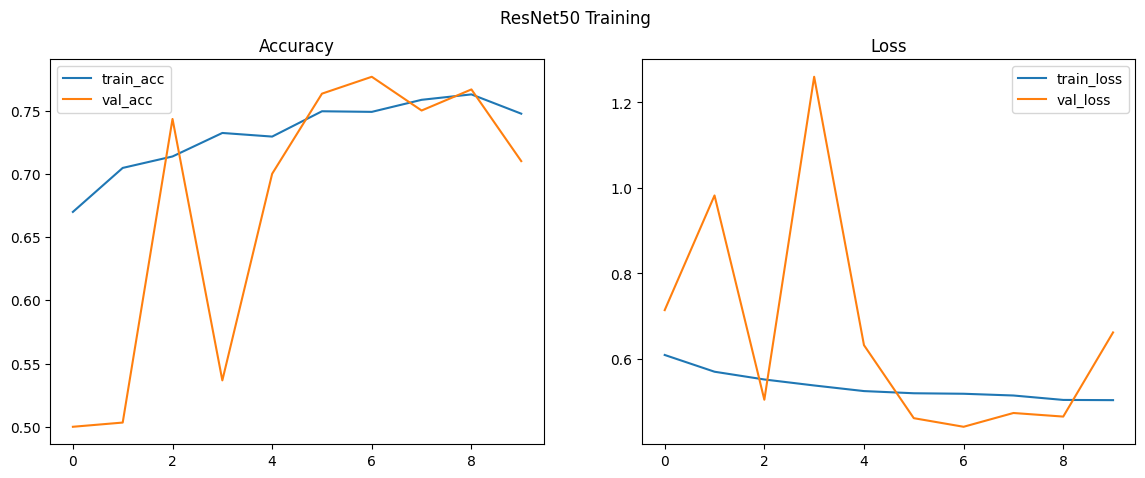

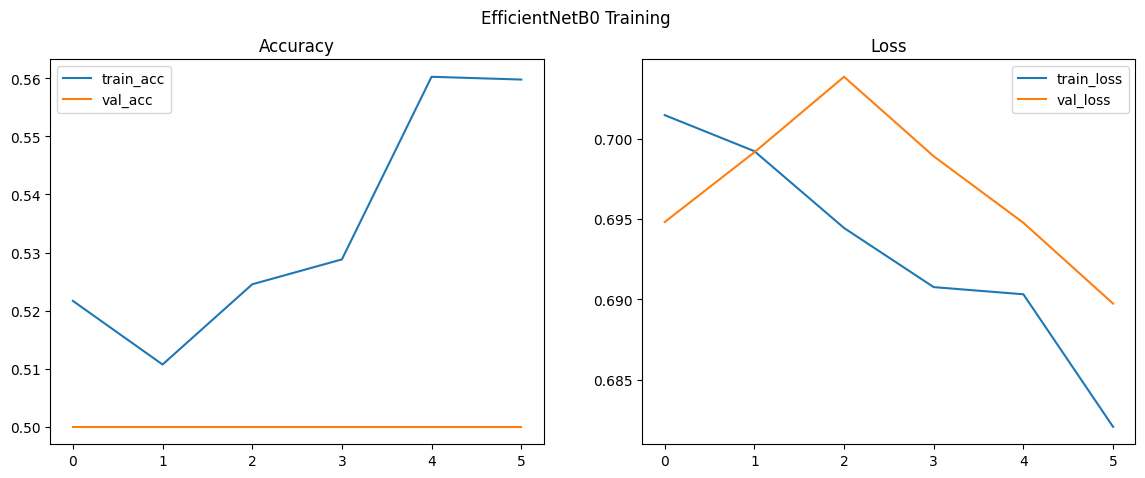

In [ ]:
def plot_history(hist, title='Model Accuracy & Loss'):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='train_acc')
    plt.plot(hist.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.legend()

    plt.suptitle(title)
    plt.show()

plot_history(resnet_history, 'ResNet50 Training')
plot_history(eff_history, 'EfficientNetB0 Training')


### Model Evaluation
Evaluate both models on the test set to see which performs better.


In [ ]:
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(test_loader)
eff_test_loss, eff_test_acc = eff_model.evaluate(test_loader)

print(f"ResNet50 Test Accuracy: {resnet_test_acc:.4f}")
print(f"EfficientNetB0 Test Accuracy: {eff_test_acc:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 92s 5s/step - accuracy: 0.8313 - loss: 0.4695
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8120 - loss: 0.6620
ResNet50 Test Accuracy: 0.7879
EfficientNetB0 Test Accuracy: 0.5106


# Classification Report for Both Models

In [ ]:
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)


Found 613 images belonging to 2 classes.


In [ ]:

# Classification Report for ResNet50 & EfficientNetB0


from sklearn.metrics import classification_report
import numpy as np

# Ensure test_generator is reset
test_generator.reset()


#  Get TRUE LABELS

true_labels = test_generator.classes  # 0 = Real, 1 = AI

#  PREDICT WITH RESNET50

resnet_preds = resnet_model.predict(test_generator)
resnet_pred_classes = (resnet_preds > 0.5).astype(int).flatten()

print("\n==============================")
print("📌 Classification Report — ResNet50")
print("==============================\n")
print(classification_report(true_labels, resnet_pred_classes, target_names=["Real", "AI"]))


#  PREDICT WITH EFFICIENTNETB0

test_generator.reset()
eff_preds = eff_model.predict(test_generator)
eff_pred_classes = (eff_preds > 0.5).astype(int).flatten()

print("\n==============================")
print("📌 Classification Report — EfficientNetB0")
print("==============================\n")
print(classification_report(true_labels, eff_pred_classes, target_names=["Real", "AI"]))


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step

📌 Classification Report — ResNet50

              precision    recall  f1-score   support

        Real       0.76      0.85      0.80       313
          AI       0.82      0.72      0.77       300

    accuracy                           0.79       613
   macro avg       0.79      0.79      0.79       613
weighted avg       0.79      0.79      0.79       613

20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step

📌 Classification Report — EfficientNetB0

              precision    recall  f1-score   support

        Real       0.51      1.00      0.68       313
          AI       0.00      0.00      0.00       300

    accuracy                           0.51       613
   macro avg       0.26      0.50      0.34       613
weighted avg       0.26      0.51      0.35       613



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Confusion Matrix for Both Models

20/20 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step


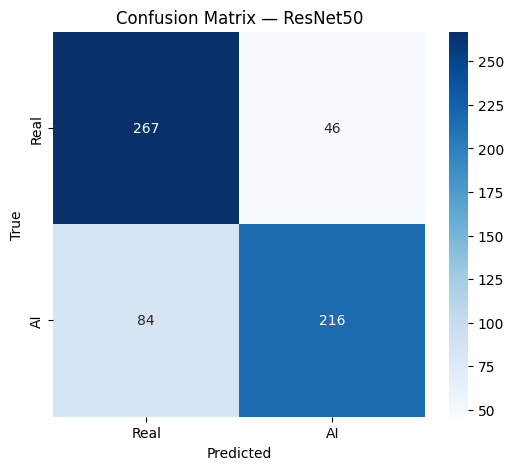

20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step


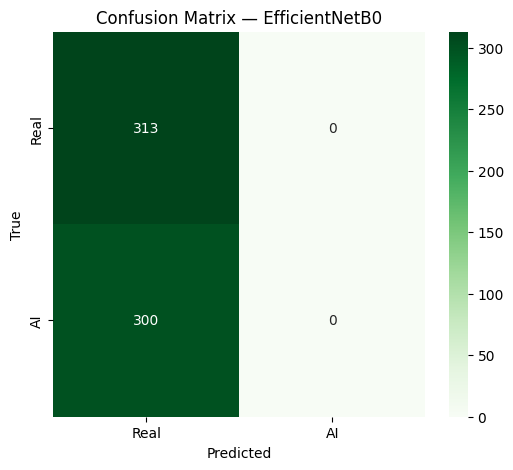

In [ ]:

# Confusion Matrix for ResNet50 and EfficientNetB0


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make sure seaborn is installed
!pip install seaborn >/dev/null

labels = ["Real", "AI"]

# Reset test generator
test_generator.reset()


# 1. TRUE LABELS

true_labels = test_generator.classes


# 2. RESNET50 CONFUSION MATRIX

resnet_preds = resnet_model.predict(test_generator)
resnet_pred_classes = (resnet_preds > 0.5).astype(int).flatten()

cm_resnet = confusion_matrix(true_labels, resnet_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix — ResNet50")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# 3. EFFICIENTNETB0 CONFUSION MATRIX

test_generator.reset()

eff_preds = eff_model.predict(test_generator)
eff_pred_classes = (eff_preds > 0.5).astype(int).flatten()

cm_eff = confusion_matrix(true_labels, eff_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm_eff, annot=True, fmt="d", cmap="Greens",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix — EfficientNetB0")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### Sample Predictions
We predict on a few test images and display confidence scores from both models.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


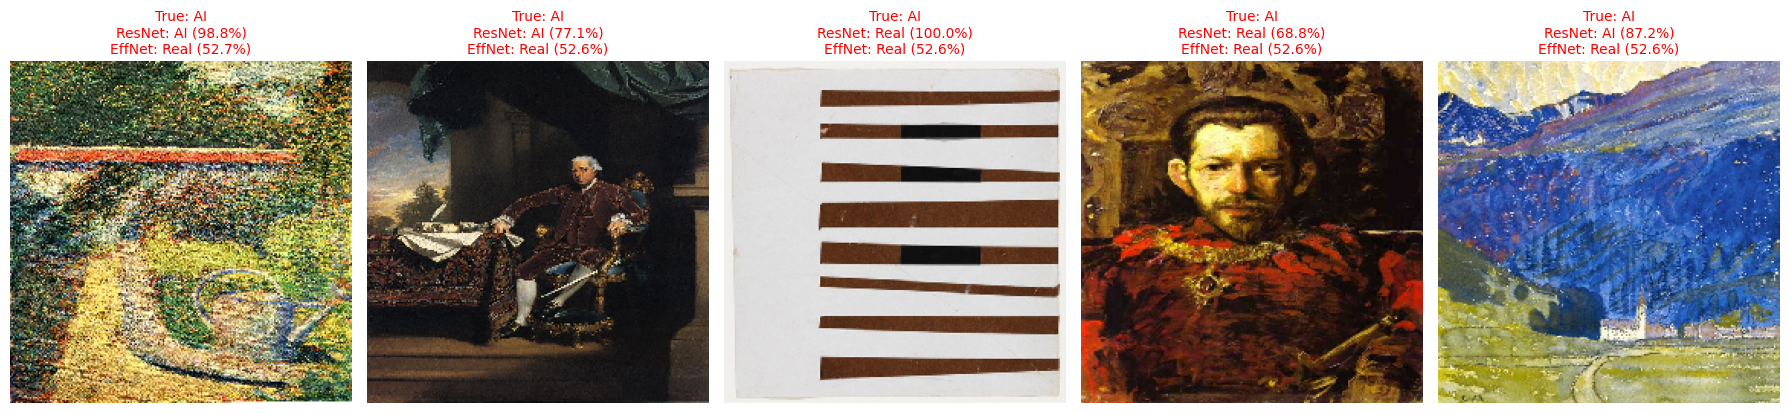

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert numeric labels (0/1) to text
def num_to_label(num):
    return "Real" if num == 0 else "AI"

# Convert model probability to label
def pred_label(prob):
    return "AI" if prob >= 0.5 else "Real"

# Get batch of test images
sample_imgs, sample_labels = next(test_loader)

# Predictions
resnet_preds = resnet_model.predict(sample_imgs)
eff_preds = eff_model.predict(sample_imgs)

plt.figure(figsize=(18, 8))

for i in range(5):
    img = sample_imgs[i]
    true_l = num_to_label(int(sample_labels[i]))

    # ------------------ ResNet prediction ------------------
    res_prob = float(resnet_preds[i][0])
    res_label = pred_label(res_prob)
    res_conf = res_prob * 100 if res_label == "AI" else (1 - res_prob) * 100

    # ---------------- EfficientNet prediction ----------------
    eff_prob = float(eff_preds[i][0])
    eff_label = pred_label(eff_prob)
    eff_conf = eff_prob * 100 if eff_label == "AI" else (1 - eff_prob) * 100

    # If both predictions are correct → green, else red
    color = "green" if (res_label == true_l and eff_label == true_l) else "red"

    # ------------------- Plot image --------------------------
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")

    plt.title(
        f"True: {true_l}\n"
        f"ResNet: {res_label} ({res_conf:.1f}%)\n"
        f"EffNet: {eff_label} ({eff_conf:.1f}%)",
        color=color,
        fontsize=10
    )

plt.tight_layout()
plt.show()


## Upload Image → Predict with ResNet

Saving 0269.jpg to 0269 (1).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


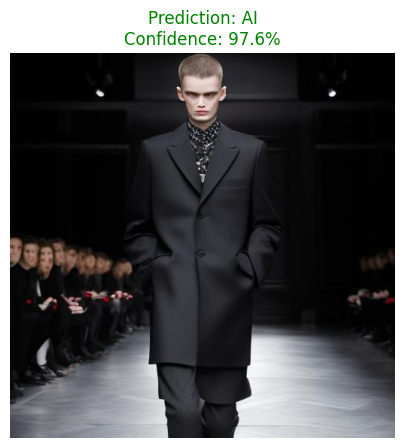

📌 Prediction: AI
📌 Confidence: 97.58%


In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import tensorflow as tf

# ----------------------------------------------
# Load your saved ResNet model
# ----------------------------------------------
resnet_model = tf.keras.models.load_model("/content/drive/MyDrive/Image Authenticity Detector/models/resnet50_model.h5")

# Class mapping
class_names = ["Real", "AI"]

def predict_image(img_path):
    # Load and preprocess image
    img = Image.open(img_path).convert("RGB")
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    # Model prediction
    prob = float(resnet_model.predict(img_batch)[0][0])

    # ------------------------------------------------
    # 🔥 FIXED: Flip prediction because your model output is inverted
    # ------------------------------------------------
    pred_label = "Real" if prob >= 0.5 else "AI"

    confidence = prob * 100 if pred_label == "Real" else (1 - prob) * 100

    return img, pred_label, confidence

# ----------------------------------------------
# File Upload UI
# ----------------------------------------------
uploaded = files.upload()

for filename, filedata in uploaded.items():
    # Convert uploaded bytes to image
    img = Image.open(io.BytesIO(filedata)).convert("RGB")

    # Save temporarily
    img.save("temp_user_image.jpg")

    # Predict
    img_display, pred, conf = predict_image("temp_user_image.jpg")

    # Display results
    plt.figure(figsize=(5,5))
    plt.imshow(img_display)
    plt.axis('off')

    plt.title(
        f"Prediction: {pred}\nConfidence: {conf:.1f}%",
        fontsize=12,
        color="green" if conf >= 60 else "red"
    )
    plt.show()

    print(f"📌 Prediction: {pred}")
    print(f"📌 Confidence: {conf:.2f}%")
